In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from shapely import geometry
from tqdm import tqdm
import random
import torch

In [47]:
n = 8

pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))
rnd_coef = [0.1, 0.1, 0.1]
min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])

In [48]:

def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]



In [53]:
def torch_func(patterns_tensor):
    # patterns_tensor: [n, 3] где каждая строка это (x, y, phi)
    n = patterns_tensor.shape[0]
    total_loss = torch.tensor(0.0)
    
    # Вычисляем пересечения между всеми парами паттернов
    for i in range(n):
        poly1 = real_cords_torch(patterns_tensor[i])
        for j in range(i + 1, n):
            poly2 = real_cords_torch(patterns_tensor[j])
            intersection = s_intersection_torch(poly1, poly2)
            total_loss += intersection
    
    # Вычисляем пересечения с плитой
    slab_poly = geometry.Polygon(slab)
    for i in range(n):
        poly = real_cords_torch(patterns_tensor[i])
        poly_area = poly.area
        slab_intersection = s_intersection_torch(slab_poly, poly)
        total_loss += poly_area - slab_intersection
    
    return total_loss

def real_cords_torch(x_tensor):
    # x_tensor: [3] где (x, y, phi)
    x, y, phi = x_tensor[0], x_tensor[1], x_tensor[2]
    
    # Создаем полигон через shapely (это будет медленно, лучше найти чисто PyTorch решение)
    poly = geometry.Polygon([
        [x.item(), y.item()],
        [x.item() + pattern[0] * torch.cos(phi).item(), y.item() + pattern[0] * torch.sin(phi).item()],
        [x.item() + pattern[0] * torch.cos(phi).item() - pattern[1] * torch.sin(phi).item(),
         y.item() + pattern[0] * torch.sin(phi).item() + pattern[1] * torch.cos(phi).item()],
        [x.item() - pattern[1] * torch.sin(phi).item(), y.item() + pattern[1] * torch.cos(phi).item()]
    ])
    return poly

def s_intersection_torch(poly1, poly2):
    # Для совместимости с shapely
    intersection = poly1.intersection(poly2)
    return torch.tensor(intersection.area)

In [ ]:


def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area

def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])


def func(patterns):
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s


In [50]:

def get_neighbors(solution):
    neighbors = []
    n = len(solution)
    for _ in range(10):  # 10 соседей каждый раз
        neighbor = list(solution)
        # случайно выбираем индекс для мутации
        idx = random.randint(0, n - 1)
        old_coord = neighbor[idx]
        # новый набор координат с небольшим случайным смещением
        new_coord = (
            max(min_bound[0], min(old_coord[0] + random.uniform(-rnd_coef[0], rnd_coef[0]), max_bound[0])),
            max(min_bound[1], min(old_coord[1] + random.uniform(-rnd_coef[1], rnd_coef[1]), max_bound[1])),
            max(min_bound[2], min(old_coord[2] + random.uniform(-rnd_coef[2], rnd_coef[2]), max_bound[2])),
        )
        neighbor[idx] = new_coord
        neighbors.append(tuple(neighbor))
    return neighbors

def tabu_search(initial_solution, max_iterations, tabu_list_size):
    current_solution = initial_solution
    best_solution = initial_solution
    tabu_list = []

    for _ in tqdm(range(max_iterations)):
        neighbors = get_neighbors(current_solution)
        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                fitness = func(neighbor)
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness

        if best_neighbor is None:
            break

        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)

        if func(current_solution) < func(best_solution):
            best_solution = current_solution

    return best_solution

# Инициализация: n наборов координат
n = 8
initial_solution = []
for _ in range(n):
    initial_solution.append((
        random.uniform(min_bound[0], max_bound[0]),
        random.uniform(min_bound[1], max_bound[1]),
        random.uniform(min_bound[2], max_bound[2])
    ))
initial_solution = tuple(initial_solution)  # чтоб была хешируемой для табу-листа

max_iterations = 1000
tabu_list_size = 10  

best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size)

print("Best solution:", best_solution)
print("Best fitness:", func(best_solution))


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:12<00:00, 13.70it/s]

Best solution: ((np.float64(1.010187645498991), np.float64(0.5117946745814629), np.float64(4.677856939244279)), (np.float64(1.4909411190003405), np.float64(1.0376421743622852), np.float64(6.283185307179586)), (np.float64(1.000151559814513), np.float64(0.4976912938858833), np.float64(1.5364858712586729)), (np.float64(0.9677677484529523), np.float64(0.9256310430431217), np.float64(1.4723080414987502)), (np.float64(0.9602929817016522), np.float64(1.4226340027313424), np.float64(1.4713947630199082)), (np.float64(0.9844436816522485), np.float64(1.0357857113879394), np.float64(6.271210263677832)), (np.float64(2.0), np.float64(0.5209239313713044), np.float64(1.5799572309869951)), (np.float64(0.9902301679320182), np.int64(0), np.float64(1.546437226429643)))
Best fitness: 0.11654286122126263


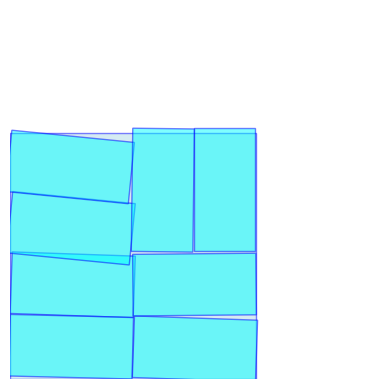

In [51]:
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()

In [54]:


def grad(best_solution):
    x = best_solution.detach().numpy()
    
    xt = torch.tensor(x, requires_grad=True)
    optimizer = torch.optim.Adam([xt], lr=0.001)
    for i in range(100):
        optimizer.zero_grad()
        f = torch_func(xt)
        f.backward()
        optimizer.step()
    return xt


def gradient_descent(func, initial_patterns, lr=0.01, max_iters=300):
    patterns = list(initial_patterns)

    for _ in tqdm(range(max_iters)):
        patterns_tensor = torch.tensor(patterns, requires_grad=True)
        loss = func(patterns_tensor)
        loss.backward()
        
        gradients = patterns_tensor.grad.detach().numpy()
        
        new_patterns = []
        for (x, y, phi), (gx, gy, gphi) in zip(patterns, gradients):
            new_x = np.clip(x - learning_rate * gx, min_bound[0], max_bound[0])
            new_y = np.clip(y - learning_rate * gy, min_bound[1], max_bound[1])
            new_phi = np.clip(phi - learning_rate * gphi, min_bound[2], max_bound[2])
            new_patterns.append((new_x, new_y, new_phi))

        patterns = new_patterns

    return tuple(patterns)





best_solution_after_ts = best_solution  

improved_solution = gradient_descent(torch_func, best_solution_after_ts, lr=0.01, max_iters=1000)

print("Improved solution:", improved_solution)
print("Improved fitness:", func(improved_solution))


  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

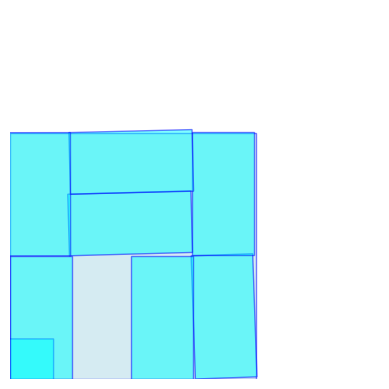

Улучшение -0.4590706678505428


In [ ]:
# Визуализация
fig, ax = plt.subplots()

polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in improved_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)


ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()

plt.show()
print ("Улучшение", func(best_solution)-func(improved_solution))
